In [1]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.3 MB/s eta 0:00:00


In [36]:
import gc, json, pickle
import optuna
import joblib
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from itertools import combinations
from joblib import Parallel, delayed
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import TimeSeriesSplit
from collections import defaultdict
from scipy.stats import pearsonr, zscore
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class DataLoader:
  def __init__(self, data_path, file_name):
    self.data_path = data_path
    self.file_name = file_name

  def load(self):
    df = pd.read_parquet(self.data_path + self.file_name)
    self.df = df.loc[:, ~((df == -np.inf).any() | (df == 0).all())]
    print('Data loaded')
    return self

  def train_split(self):
    label = self.df['label']
    qty_vol = self.df[['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']]
    X_ = self.df.drop(['label', 'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume'], axis=1)
    return X_, qty_vol, label

  def test_split(self):
    qty_vol = self.df[['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']]
    X_ = self.df.drop(['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume'], axis=1)
    return X_, qty_vol

  def load_features_json_list(self):
    with open(self.data_path + self.file_name, 'r') as f:
      return json.load(f)

  def load_clusters_pkl(self):
    with open(self.data_path + self.file_name, 'rb') as f:
      return pickle.load(f)

  def read_correlations_csv(self):
    return pd.read_csv(self.data_path + self.file_name)

In [29]:
class CorrelationAnalyzer:
  def __init__(self, df = None, feature = None, label = None):
    self.feature = feature
    self.label = label
    self.df = df

  def _correlation(self, feature, label):
    '''
    Calcualte the Pearson correlation and p-value
    for a single feature and Y
    '''
    r, p = pearsonr(feature, label)
    return r, p

  def compute_correlations_features(self):
    '''
    Calcualte the Pearson correlation and p-between each feature in parallel
    '''

    features = self.df.columns
    n=len(features)

    corr_matrix = np.eye(n)
    pval_matrix = np.zeros((n, n))
    pairs = list(combinations(features, 2))

    results = Parallel(n_jobs=-1)(
        delayed(pearsonr)(
            self.df[p[0]].values, self.df[p[1]].values) for p in pairs)

    for (i, j), (r, p) in zip(pairs, results):
      corr_matrix[i, j] = corr_matrix[j, i] = r
      pval_matrix[i, j] = pval_matrix[j, i] = p

    corr_df = pd.DataFrame(corr_matrix, index=features, columns=features)
    pval_df = pd.DataFrame(pval_matrix, index=features, columns=features)

    return corr_df, pval_df

  def compute_correlations_in_window(self, window='2D'):
    '''
    Calcualte the Pearson correlation and p-value
    for each window between each feature and Y
    '''
    grouped_feature = self.feature.groupby(pd.Grouper(freq=window))
    grouped_label = self.label.groupby(pd.Grouper(freq=window))
    results = []
    for (period_start_feature, df_window_feature,
         _, df_window_label) in (
        zip(grouped_feature, grouped_label)):

      output = Parallel(n_jobs=4)(
          delayed(self._correlation)(f, l) for f, l in (
              zip(df_window_feature, df_window_label)
              )
          )

      for feature, r, p in output:
        results.append({
            'period_start': period_start_feature,
            'feature': feature,
            'correlation': r,
            'p_value': p
            })

    return pd.DataFrame(results)

  def score_features(self, df_correlations, epsilon=1e-6):
    '''
    Score features based on their correlation with Y as a:
      base_score:
        correlation_mean / correlation_std

      adjusted_score:
        base_score * (1 / p_value_mean)
    '''
    summary = df_correlations.groupby('feature').agg({
        'correlation': ['mean', 'std'],
        'p_value': 'mean'
        })

    summary['base_score'] = (
        abs(summary[('correlation', 'mean')]) / (summary[('correlation', 'std')]
                                                 + epsilon)
    )

    summary['adjusted_score'] = (summary['base_score'] *
     (1 / summary[('p_value', 'mean')] + epsilon))

    return summary

  def number_of_features_to_select(self, summary, score='adjusted_score'):
    df_sorted = summary.sort_values(by=score, ascending=False).reset_index()
    df_sorted.rename(columns={"index": "feature"}, inplace=True)
    df_sorted["cumulative_score"] = df_sorted[score].cumsum()
    df_sorted["normalized_score"] = df_sorted["cumulative_score"] / df_sorted["cumulative_score"].iloc[-1]
    df_sorted["feature_index"] = np.arange(1, len(df_sorted) + 1)

    first_point = np.array([0, df_sorted["normalized_score"].iloc[0]])
    last_point = np.array([len(df_sorted) - 1, df_sorted["normalized_score"].iloc[-1]])
    line_vec = last_point - first_point
    line_vec_norm = line_vec / np.linalg.norm(line_vec)

    distances = []
    for i in range(len(df_sorted)):
        point = np.array([i, df_sorted["normalized_score"].iloc[i]])
        vec_from_first = point - first_point
        proj_len = np.dot(vec_from_first, line_vec_norm)
        proj_point = first_point + proj_len * line_vec_norm
        dist = np.linalg.norm(point - proj_point)
        distances.append(dist)

    elbow_index = int(np.argmax(distances))
    optimal_n_features = elbow_index + 1
    selected_features = df_sorted["feature"].iloc[:optimal_n_features].tolist()

    return optimal_n_features, selected_features, df_sorted

  def select_top_features(self, summary, top_k=55, score='adjusted_score'):
    sorted_summary = summary.sort_values(score, ascending=False)
    top_k_df = sorted_summary.head(top_k)
    return top_k_df.index.tolist()

  def select_pairs_high_correlation(self, df_correlations, threshold=0.93):
    return df_correlations[
        (df_correlations['r'] >= threshold) |
        (df_correlations['r'] <= -threshold)
    ]

  def find_correlated_clusters(self, df_correlations):
    clusters = []
    for index, row in df_correlations.iterrows():
      f1 = row['feature1']
      f2 = row['feature2']

      f1_cluster_idx = -1
      f2_cluster_idx = -1

      for i, cluster in enumerate(clusters):
        if f1 in cluster:
          f1_cluster_idx = i
        if f2 in cluster:
          f2_cluster_idx = i

      if f1_cluster_idx == -1 and f2_cluster_idx == -1:
        clusters.append({f1, f2})

      elif f1_cluster_idx != -1 and f2_cluster_idx == -1:
        clusters[f1_cluster_idx].add(f2)

      elif f1_cluster_idx == -1 and f2_cluster_idx != -1:
        clusters[f2_cluster_idx].add(f1)

      elif f1_cluster_idx != -1 and f2_cluster_idx != -1 and f1_cluster_idx != f2_cluster_idx:
        merged_cluster = clusters[f1_cluster_idx].union(clusters[f2_cluster_idx])

        if f1_cluster_idx > f2_cluster_idx:
          del clusters[f1_cluster_idx]
          del clusters[f2_cluster_idx]

        else:
          del clusters[f2_cluster_idx]
          del clusters[f1_cluster_idx]

        clusters.append(merged_cluster)

    return clusters

In [48]:
class VIFBasedFeatureSelector:
  def __init__(self, df, vif_threshold = 5.0):
    self.df = df
    self.vif_threshold = vif_threshold
    self.faetures_to_drop = set()
    self.processed_df = None

  def _calculate_vif_for_subset(self, df_subset):
    df_with_const = add_constant(df_subset, has_constant='add')

    vifs_data = []
    for i in range(df_with_const.shape[1]):
      col_name = df_with_const.columns[i]
      if col_name != 'const':
        vif_value = variance_inflation_factor(df_with_const.values, i)
        vifs_data.append({'feature': col_name, 'VIF': vif_value})


    return pd.DataFrame(vifs_data)

  def select_features(self, feature_clusters):
    self.features_to_drop = set()

    for _, cluster_set in enumerate(feature_clusters):
      features_in_this_cluster_to_keep = list(cluster_set)
      features_in_this_cluster_to_keep = [f for f in features_in_this_cluster_to_keep if f in self.df.columns]

      if not features_in_this_cluster_to_keep:
        continue
      if len(features_in_this_cluster_to_keep) < 2:
        continue

      while True:
        df_subset_for_vif = self.df[features_in_this_cluster_to_keep]

        if df_subset_for_vif.shape[1] < 2:
          break

        vif_df = self._calculate_vif_for_subset(df_subset_for_vif)

        max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax()]

        if max_vif_feature['VIF'] >= self.vif_threshold:
          feature_to_remove = max_vif_feature['feature']
          features_in_this_cluster_to_keep.remove(feature_to_remove)
          self.features_to_drop.add(feature_to_remove)
        else:
          break

    all_original_features = set(self.df.columns)
    features_to_keep_overall = all_original_features - self.features_to_drop
    self.processed_df = self.df[list(features_to_keep_overall)]

    return self.processed_df, self.features_to_drop

In [6]:
# Features
# Group 1 - X1, X2 ....
# Group 2 - _qty, vol

In [7]:
# Filepaths
dataPathLoad = '/content/drive/MyDrive/Colab Notebooks/DRW/data/'
dataPathSave = '/content/drive/MyDrive/Colab Notebooks/DRW/data/v8/'
fileNameTrain = 'train.parquet'

In [8]:
# Load train data and remove -inf columns and columns full of 0
loader = DataLoader(dataPathLoad, fileNameTrain)
features_group1, features_group2, label = loader.load().train_split()
del loader
gc.collect()

Data loaded


17

In [ ]:
combinationsFeatures = list(combinations(features_group1, 2))

In [ ]:
resultsCombPearson = {
    'feature1': [],
    'feature2': [],
    'r': [],
    'p': []
}
for comb in combinationsFeatures:
  r, p = pearsonr(features_group1[comb[0]], features_group1[comb[1]])
  resultsCombPearson['feature1'].append(comb[0])
  resultsCombPearson['feature2'].append(comb[1])
  resultsCombPearson['r'].append(r)
  resultsCombPearson['p'].append(p)

In [ ]:
# Dataframe with results
dfCombPearson = pd.DataFrame(resultsCombPearson)

In [ ]:
# Transform to correlation matrix
corrMatrix = dfCombPearson.pivot(index='feature1', columns='feature2', values='r')

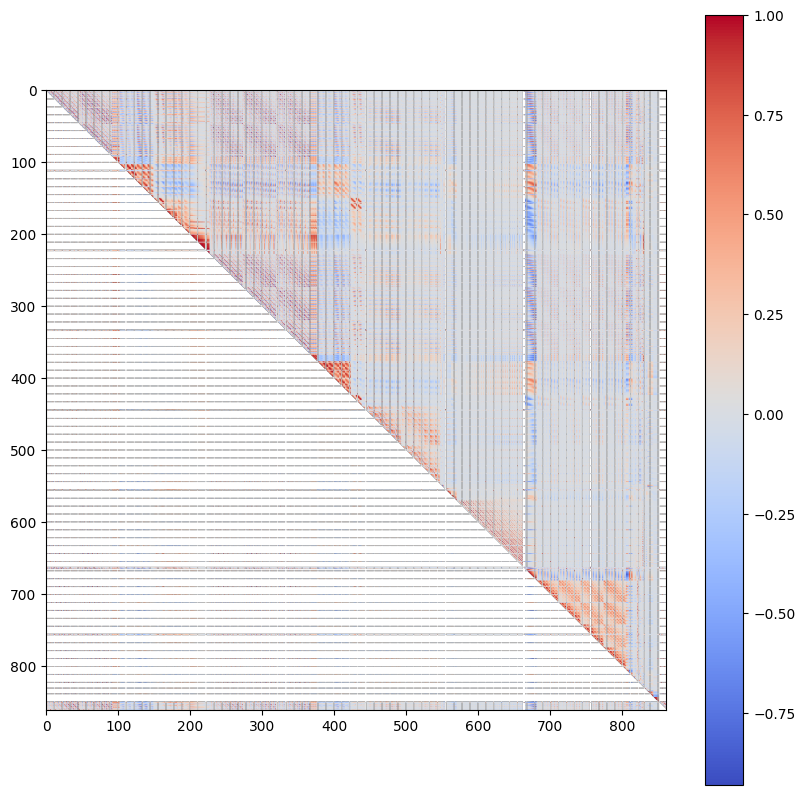

In [ ]:
# Heatmap of correlations
plt.figure(figsize=(10, 10))
plt.imshow(corrMatrix, cmap='coolwarm')
plt.colorbar()
plt.show()

In [ ]:
# Save to df
dfCombPearson.to_csv(dataPathSave + 'combPearson.csv')

In [12]:
dfCombPearson = DataLoader(dataPathSave, 'combPearson.csv').read_correlations_csv()
dfCombPearson = dfCombPearson.drop(['Unnamed: 0'], axis=1)

In [30]:
# Derive highly correlated clusters
correlated_features = CorrelationAnalyzer().select_pairs_high_correlation(
    dfCombPearson).reset_index(drop=True)

clusters = CorrelationAnalyzer().find_correlated_clusters(correlated_features)

In [ ]:
# Calculate VIF within eahc cluster
selector = VIFBasedFeatureSelector(features_group1)
processed_df, dropped_features = selector.select_features(clusters)